<a href="https://colab.research.google.com/github/tuchinhung/Quantu-ML/blob/main/Exemplo_uso_PennyLena.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%%capture 

# Comment this out if you don't want to install pennylane from this notebook
!pip install pennylane

# Comment this out if you don't want to install matplotlib from this notebook
!pip install matplotlib

In [5]:
import pennylane as qml
from pennylane import numpy as np # This will import a special, "differentiable" version of numpy.

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)

#1. The three basic ingredients

---
Machine Learning
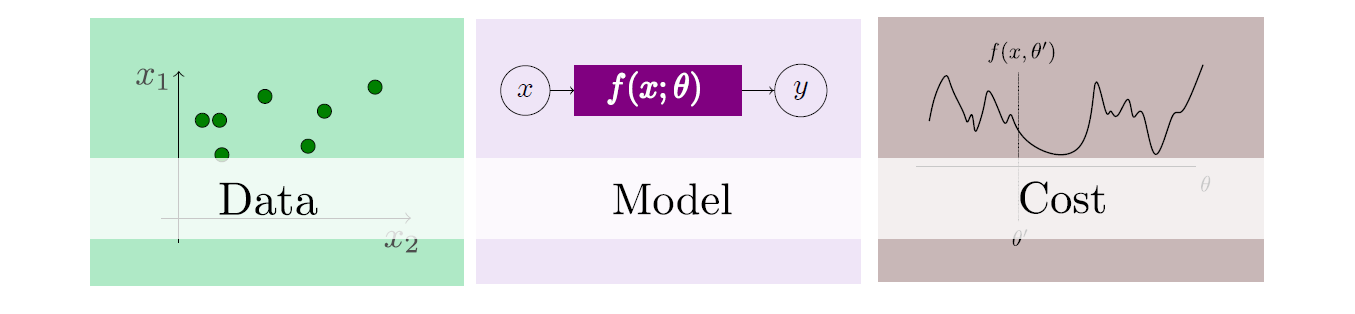

---







Use amostras de dados para construir um modelo que minimize o custo de dados não vistos.

---
Linear Models

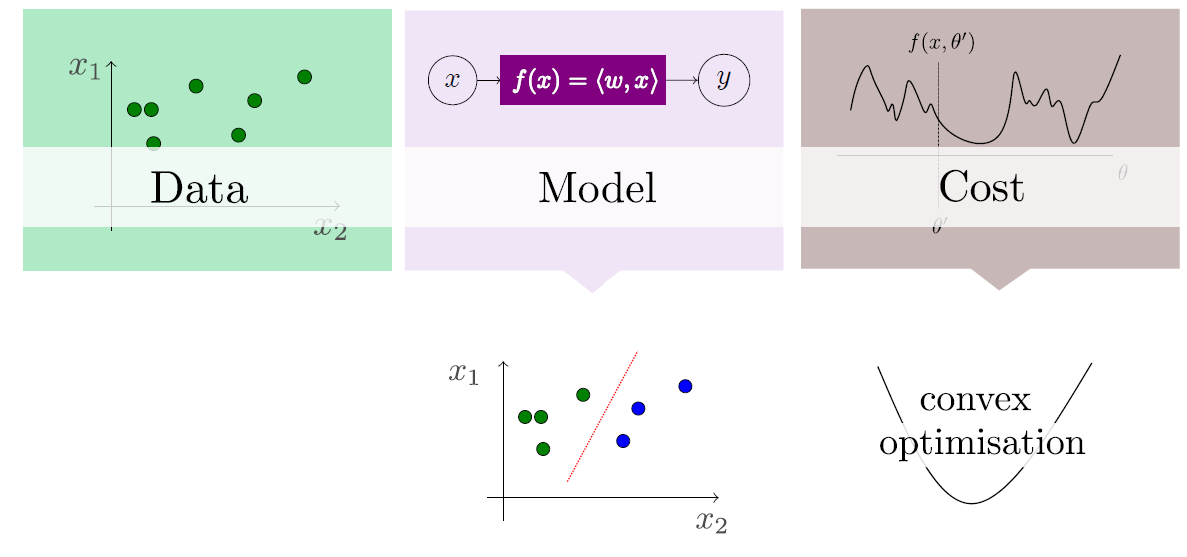
---





Data

In [6]:
n_samples = 100
X0 = np.array([[np.random.normal(loc=-1, scale=1), 
                np.random.normal(loc=1, scale=1)] for i in range(n_samples//2)]) 
X1 = np.array([[np.random.normal(loc=1, scale=1), 
                np.random.normal(loc=-1, scale=1)] for i in range(n_samples//2)]) 
X = np.concatenate([X0, X1], axis=0)
Y = np.concatenate([-np.ones(50), np.ones(50)], axis=0)
data = list(zip(X, Y))

Model family

In [7]:
def model(x, w):
    return np.dot(x, w)

w = np.array([-0.2, -0.2])

model(X0[0], w)

-0.07168997036800961

Cost function

In [8]:
def loss(a, b):
    return (a - b)**2
def average_loss(w, data):
    c = 0
    for x, y in data:
        prediction = model(x, w)
        c += loss(prediction, y)
    return c/len(data)

#2. Automatic computation of gradients

In [9]:
w = np.array([0.1, -0.1])
average_loss(w, data)

0.6705617111275896

In [10]:
gradient_fn = qml.grad(average_loss, argnum=0)
gradient_fn(w, data)

array([-1.50619253,  1.25442995])

#3. Training with gradient descent

In [11]:
def model_with_bias(x, w, b):
    return np.dot(x, w) + b

def average_loss(w, b, data):
    c = 0
    for x, y in data:
        prediction = model_with_bias(x, w, b)
        c += loss(prediction, y)
    return c/len(data)

gradient_fn_w = qml.grad(average_loss, argnum=0)
gradient_fn_b = qml.grad(average_loss, argnum=1)

w_init = np.random.random(size=(2,))
w = np.array(w_init)
b = np.array(0.0) # start with zero bias

for i in range(15):
    w_new = w - 0.05*gradient_fn_w(w, b, data)
    b_new = b - 0.05*gradient_fn_b(w, b, data)
    print(average_loss(w_new, b_new, data))
    w = w_new
    b = b_new

1.3488121477541597
1.0997874532292236
0.9256009051357554
0.7985621334225754
0.7026027773731548
0.628100877849561
0.5690671951101229
0.521605195517599
0.4830597156035511
0.4515395126151164
0.42564403878458035
0.40430277479729804
0.3866774171010441
0.3720998180223305
0.3600307816347295


Copie e cole o código do bloco de notas anterior aqui e substitua o modelo clássico pela função quantum_model. Isso permitirá que você treine o modelo!

Adicione um termo de polarização ao modelo quântico.


In [12]:
import pennylane as qml
from pennylane import numpy as np

In [13]:
dev = qml.device('default.qubit', wires=2)

In [14]:
@qml.qnode(dev)
def quantum_model(x, w):
    qml.templates.AngleEmbedding(x, wires=[0, 1])
    qml.templates.BasicEntanglerLayers(w, wires=[0, 1])
    return qml.expval(qml.PauliZ(wires=0))


gradient_fn = qml.grad(quantum_model)


In [15]:
n_samples = 100
X0 = np.array([[np.random.normal(loc=-1, scale=1), 
                np.random.normal(loc=1, scale=1)] for i in range(n_samples//2)]) 
X1 = np.array([[np.random.normal(loc=1, scale=1), 
                np.random.normal(loc=-1, scale=1)] for i in range(n_samples//2)]) 

X = np.concatenate([X0, X1], axis=0)
Y = np.concatenate([-np.ones(50), np.ones(50)], axis=0)
data = list(zip(X, Y))

def model_with_bias(x, w, b):
    return quantum_model(x, w) + b

def loss(a, b):
    return (a - b)**2

def average_loss(w, b, data):
    c = 0
    for x, y in data:
        prediction = model_with_bias(x, w, b)
        c += loss(prediction, y)
    return c/len(data)

gradient_fn_w = qml.grad(average_loss, argnum=0)
gradient_fn_b = qml.grad(average_loss, argnum=1)

w_init = np.random.random(size=(3, 2))
w = np.array(w_init)
b = np.array(0.0) # start with zero bias

for i in range(15):
    w_new = w - 0.05*gradient_fn_w(w, b, data)
    b_new = b - 0.05*gradient_fn_b(w, b, data)
    print(average_loss(w_new, b_new, data))
    w = w_new
    b = b_new


1.7791805797160398
1.6948218558155512
1.612041766381709
1.5324480121086368
1.4573465808239927
1.3876685770544581
1.3239533034048048
1.2663789912836811
1.214825140170182
1.16894907642031
1.1282624081422739
1.0921980489683467
1.0601633773272159
1.0315787959672544
1.0059031975656103


Substitua a etapa de otimização codificada manualmente por um otimizador PennyLane nativo.



In [16]:
opt = qml.GradientDescentOptimizer(0.05)
for i in range(15):
    ([w, b], cst) = opt.step_and_cost(lambda w_, b_: average_loss(w_, b_, data), w, b)
    print(cst)

1.0059031975656103
0.9826488521036112
0.9613884060332485
0.9417563951909753
0.9234471963890646
0.9062108439953359
0.8898477023014942
0.8742026429551839
0.8591591298745007
0.8446334483471815
0.8305692121366813
0.8169322242291516
0.803705737611687
0.790886149630083
0.7784791578088275
